# K-NearestNeighbour Sex Classification

## Initial Setup

### Imports

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import os
import csv

from collections import OrderedDict
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from sklearn.cross_validation import LeaveOneOut, LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import DistanceMetric
from scipy.linalg import svd

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

np.random.seed(12345678)  # for reproducibility, set random seed

### Getting File Lists

In [2]:
# Initializing dataset names
dataset_names = list(('KKI2009', 'MRN114', 'SWU4', 'BNU1', 'BNU3'))
# dataset_names = list(('KKI2009', 'MRN114', 'BNU1', 'BNU3'))

basepath = '/Users/gkiar/code/classes/upward-spiral/grelliam/data/'
atlas = 'desikan'
dir_names = [basepath + '/' + atlas + '/' + d for d in dataset_names]

#  Crawls directories and creates a dictionary entry of file names for each
#  dataset which we plan to process.
fs = OrderedDict()
for idx, dd in enumerate(dataset_names):
    fs[dd] = [root + "/" + fl for root, dirs, files in os.walk(dir_names[idx])
              for fl in files if fl.endswith(".graphml")]

ps = {os.path.splitext(os.path.basename(fl))[0] : root + "/" + fl
      for root, dirs, files in os.walk(basepath+'phenotypes')
      for fl in files if fl.endswith(".csv") }

print "Datasets: " + ", ".join([fkey + ' (' + str(len(fs[fkey])) + ')'
                                for fkey in fs])
print "Total Subjects: %d" % (sum([len(fs[key]) for key in fs]))


Datasets: KKI2009 (42), MRN114 (114), SWU4 (454), BNU1 (81), BNU3 (46)
Total Subjects: 737


### Declaring Graph Read Helper Functions

In [3]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print "Loading: " + files
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_graphml(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    for idx, name in enumerate(names):
        if verb:
            print "Loading Dataset: " + name
        # The key for the dictionary of graphs is the dataset name
        graphs[name] = loadGraphs(fs[name], verb=verb)
    return graphs

### Reading Graphs

In [4]:
graphs = constructGraphDict(dataset_names, fs, verb=False)

### Reading Phenotypes

In [5]:
phenotypes = OrderedDict()
for dataset in dataset_names:
    tmp = csv.reader(open(ps[dataset]))
    pheno = OrderedDict()
    if dataset == 'KKI2009':
        triple = [[t[1].strip(), t[4], int(t[5] == 'M')] for t in tmp][1:]  # female=F->0, male=M->1
    elif dataset == 'MRN114':
        triple = [[t[0].strip(), t[3], int(t[2] == '1')] for t in tmp][1:]  # female=0->0, male=1->1
    else:
        triple = [[t[0].strip(), t[2], int(t[3] == '2')] for t in tmp
                  if t[3] != '#' and t[2] != '#'][1:]  # female=1->0, male=2->1
    
    for idx, trip in enumerate(triple):
        pheno[trip[0]] = trip[1:]
    phenotypes[dataset] = pheno

### Converting Graphs to Vectors and Phenotypes to List

In [6]:
N = nx.number_of_nodes(graphs[graphs.keys()[0]][graphs[graphs.keys()[0]].keys()[0]])
feat = np.empty((0, int(sp.special.binom(N,2))), int)
dats = list(())
ages = np.array(())
sexy = np.array(())
sbjs = list(())


for idx1, dset in enumerate(graphs):
    for idx2, subj in enumerate(graphs[dset]):
        A = nx.adjacency_matrix(graphs[dset][subj]).todense()
        Au = A[np.triu_indices(A.shape[0], 1)]
        feat = np.append(feat, Au, axis=0)
        dats.append(dset)

        try:
            subj_id = str(int(subj.split('_')[1]))
        except:
            subj_id = subj.split('_')[1]

        sbjs.append(subj_id)

        ages = np.append(ages, int(phenotypes[dset][subj_id][0]))
        sexy = np.append(sexy, int(phenotypes[dset][subj_id][1]))
# print feat.shape, ages.shape, sexy.shape
# print sum(sexy == 0), sum(sexy == 1)
# print dats

---------

---------

## Classify Graphs

### KNN LOO Scan Cross Validation

In [7]:
mean_loo_scan = np.array(())
std_loo_scan = np.array(())
neighbourhoods = (np.arange(19)+2)*2-1
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    loo = LeaveOneOut(len(sexy))
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=loo)
    mean_loo_scan = np.append(mean_loo_scan, score.mean())
    std_loo_scan = np.append(std_loo_scan, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Subject Cross Validation

In [8]:
mean_loo_subj = np.array(())
std_loo_subj = np.array(())
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    lolo = LeaveOneLabelOut(sbjs)
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=lolo)
    mean_loo_subj = np.append(mean_loo_subj, score.mean())
    std_loo_subj = np.append(std_loo_subj, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Dataset

In [9]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dsetx = np.array(())
knn_loo_dsety = np.array(())
for i in neighbourhoods:
    knn_loo_dsetx = np.append(knn_loo_dsetx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dsety = np.append(knn_loo_dsety, knn[i])

### KNN LOO Dataset with PCA 

In [10]:
knn_pca = OrderedDict()
dims = 150

for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]

        # take SVD and rotate data
        u, s, vh = svd(ft_train)
        ft_train_t = np.dot(u,np.diag(s))[:, 0:dims]
        classif.fit(ft_train_t, sx_train)

        ft_test_t = np.dot(ft_test, vh)[:, 0:dims]
        score = classif.score(ft_test_t, sx_test)
        tmp = np.append(tmp, score)

#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn_pca[i] = tmp

knn_loo_dset_pcax = np.array(())
knn_loo_dset_pcay = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pcax = np.append(knn_loo_dset_pcax, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pcay = np.append(knn_loo_dset_pcay, knn[i])

### KNN LOO Dataset after subtracting cohort mean

In [11]:
feat_cm = np.copy(feat)
# print feat[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_cm[ind < 1] = updated
# print feat_cm[600]

In [12]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_cm[ind < 1] # current dataset is test
        ft_test = feat_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_cmx = np.array(())
knn_loo_dset_cmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_cmx = np.append(knn_loo_dset_cmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_cmy = np.append(knn_loo_dset_cmy, knn[i])

### KNN LOO Dataset after subtracting population and then cohort means

In [13]:
pm = np.mean(feat, axis=0)
feat_pm = feat - pm

feat_pm_cm = np.copy(feat_pm)
# print feat_pm[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_pm_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_pm_cm[ind < 1] = updated
# print feat_pm_cm[600]

In [14]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_pm_cm[ind < 1] # current dataset is test
        ft_test = feat_pm_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_pmcmx = np.array(())
knn_loo_dset_pmcmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pmcmx = np.append(knn_loo_dset_pmcmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pmcmy = np.append(knn_loo_dset_pmcmy, knn[i])

### KNN LOO Dataset after normalizing data

In [15]:
feat_un = normalize(feat)

In [17]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_un[ind < 1] # current dataset is test
        ft_test = feat_un[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f" % (score)
    knn[i] = tmp

knn_loo_dset_unx = np.array(())
knn_loo_dset_uny = np.array(())
for i in neighbourhoods:
    knn_loo_dset_unx = np.append(knn_loo_dset_unx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_uny = np.append(knn_loo_dset_uny, knn[i])

---------

---------

## Save the things

In [18]:
result_file = '../../data/graphs/classification_results.npz'
np.savez(result_file,
         neighbourhoods=neighbourhoods,
         mean_loo_scan=mean_loo_scan, std_loo_scan=std_loo_scan,
         mean_loo_subj=mean_loo_subj, std_loo_subj=std_loo_subj,
         knn_loo_dsetx=knn_loo_dsetx, knn_loo_dsety=knn_loo_dsety,
         knn_loo_dset_cmx=knn_loo_dset_cmx, knn_loo_dset_cmy=knn_loo_dset_cmy,
         knn_loo_dset_pmcmx=knn_loo_dset_pmcmx, knn_loo_dset_pmcmy=knn_loo_dset_pmcmy,
         knn_loo_dset_unx=knn_loo_dset_unx, knn_loo_dset_uny=knn_loo_dset_uny,
         knn_loo_dset_pcax=knn_loo_dset_unx, knn_loo_dset_pcay=knn_loo_dset_uny)

feature_file = '../../data/graphs/classified_vectors.npz'
np.savez(feature_file,
         ages=ages,
         sexy=sexy,
         sbjs=sbjs,
         feat=feat,
         feat_cm=feat_cm,
         feat_pm_cm=feat_pm_cm,
         feat_un=feat_un)

---------

---------

## Load the things

In [96]:
feature_file = '../../data/graphs/classified_vectors.npz'
result_file = '../../data/graphs/classification_results.npz'

In [97]:
from numpy import array
dat = np.load(feature_file)
dat.files
d2 = np.load(result_file)
for key in d2:
    exec('{KEY} = {VALUE}'.format(KEY = key, VALUE = repr(d2[key]))) 

---------

---------

## Plot the things

### Plotting as errorbars

In [98]:
knn_loo_dsetx = np.floor(knn_loo_dsetx)
knn_loo_dset_pcax = np.floor(knn_loo_dset_pcax)
knn_loo_dset_cmx = np.floor(knn_loo_dset_cmx)
knn_loo_dset_pmcmx= np.floor(knn_loo_dset_pmcmx)
knn_loo_dset_unx = np.floor(knn_loo_dset_unx)

mean_loo_dset = np.array(())
std_loo_dset = np.array(())

mean_loo_dset_pca = np.array(())
std_loo_dset_pca = np.array(())

mean_loo_dset_cm = np.array(())
std_loo_dset_cm = np.array(())

mean_loo_dset_pmcm = np.array(())
std_loo_dset_pmcm = np.array(())

mean_loo_dset_un = np.array(())
std_loo_dset_un = np.array(())

for idx in neighbourhoods:
    tmp = knn_loo_dsety[knn_loo_dsetx == idx]
#     print len(tmp)
    mean_loo_dset = np.append(mean_loo_dset, np.mean(tmp))
    std_loo_dset = np.append(std_loo_dset, np.std(tmp))

    tmp_pca = knn_loo_dset_pcay[knn_loo_dset_pcax == idx]
#     print len(tmp_pca)
    mean_loo_dset_pca = np.append(mean_loo_dset_pca, np.mean(tmp_pca))
    std_loo_dset_pca = np.append(std_loo_dset_pca, np.std(tmp_pca))
    
    tmp_cm = knn_loo_dset_cmy[knn_loo_dset_cmx == idx]
#     print len(tmp_cm)
    mean_loo_dset_cm = np.append(mean_loo_dset_cm, np.mean(tmp_cm))
    std_loo_dset_cm = np.append(std_loo_dset_cm, np.std(tmp_cm))

    tmp_pmcm = knn_loo_dset_pmcmy[knn_loo_dset_pmcmx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_pmcm = np.append(mean_loo_dset_pmcm, np.mean(tmp_pmcm))
    std_loo_dset_pmcm = np.append(std_loo_dset_pmcm, np.std(tmp_pmcm))
    
    tmp_pmcm = knn_loo_dset_uny[knn_loo_dset_unx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_un = np.append(mean_loo_dset_un, np.mean(tmp_pmcm))
    std_loo_dset_un = np.append(std_loo_dset_un, np.std(tmp_pmcm))
    
print len(std_loo_dset_cm), len(std_loo_dset_pca), len(mean_loo_dset_cm),
print len(std_loo_dset_pmcm), len(mean_loo_dset_pmcm), len(mean_loo_dset_un)

19 19 19 19 19 19


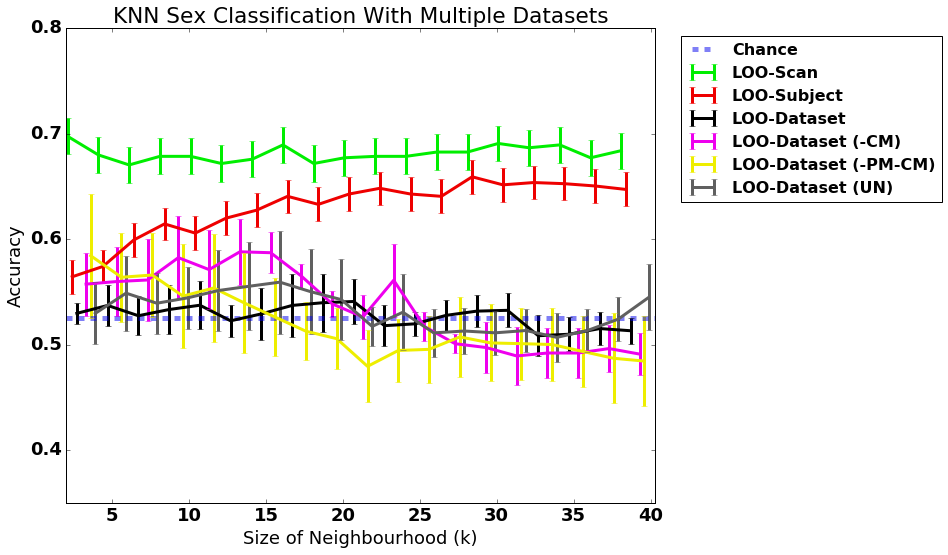

In [99]:
fig = plt.figure(figsize=(1.2*8,8))
plt.errorbar(neighbourhoods-0.9, mean_loo_scan, std_loo_scan/np.sqrt(len(sexy)), lw=3, color='#00ee00')
plt.errorbar(neighbourhoods-0.6, mean_loo_subj, std_loo_subj/np.sqrt(len(sexy)), lw=3, color='#ee0000')
plt.hold(True)
plt.axhline(sum(sexy)/len(sexy), linestyle='--', lw=5, alpha=0.5, color="#0000ee")
plt.errorbar(neighbourhoods-0.3, mean_loo_dset, std_loo_dset/np.sqrt(len(dataset*1)), lw=3, color='#000000')
plt.errorbar(neighbourhoods+0.3, mean_loo_dset_cm, std_loo_dset_cm/np.sqrt(len(dataset*1)), lw=3, color='#ee00ee')
plt.errorbar(neighbourhoods+0.6, mean_loo_dset_pmcm, std_loo_dset_pmcm/np.sqrt(len(dataset*1)), lw=3, color='#eeee00')
plt.errorbar(neighbourhoods+0.9, mean_loo_dset_un, std_loo_dset_un/np.sqrt(len(dataset*1)), lw=3, color='#606060')

# plt.ylim((0.5, 0.7))
# plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlim([2, 40.3])
plt.ylim([0.35, 0.8])
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('KNN Sex Classification With Multiple Datasets')
lgd = plt.legend(('Chance', 'LOO-Scan', 'LOO-Subject', 'LOO-Dataset',
                  'LOO-Dataset (-CM)', 'LOO-Dataset (-PM-CM)', 'LOO-Dataset (UN)'),
                 fontsize=16, bbox_to_anchor = (1.5, 1))
plt.tight_layout(1)
plt.savefig('../../figs/graphs/classification/knn_class_desikan.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

---------
## Regress Graphs

### KNN LOO Dataset Regression

In [69]:
knn_age = OrderedDict()
for i in np.arange(20):
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
#     print "============="
#     print "K nearest Neighbors: %d" % (2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        ag_train = ages[ind < 1]
        ag_test = ages[ind >= 1]
        regress.fit(ft_train, ag_train)
        score = regress.score(ft_test, ag_test)
        tmp = np.append(tmp, score)
#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
    knn_age[i] = tmp

### KNN LOO Scan

In [70]:
mean_loo_scan = np.array(())
std_loo_scan = np.array(())
neighbourhoods = (np.arange(19)+2)*2-1
print "Neighbourhoods complete:",
for i in neighbourhoods:
    regress = KNeighborsRegressor(i)
    loo = LeaveOneOut(len(ages))
    score = cross_validation.cross_val_score(regress, feat, ages, cv=loo)
    mean_loo_scan = np.append(mean_loo_scan, score.mean())
    std_loo_scan = np.append(std_loo_scan, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


In [73]:
mean_loo_scan

array([ 0.11126187,  0.05970149,  0.03934871,  0.03799186,  0.02578019,
        0.02170963,  0.0339213 ,  0.02985075,  0.01763908,  0.01221167,
        0.02170963,  0.01899593,  0.01221167,  0.01763908,  0.02170963,
        0.00949796,  0.00678426,  0.02035278,  0.01085482])

### KNN LOO Subject Cross Validation

In [74]:
mean_loo_subj = np.array(())
std_loo_subj = np.array(())
print "Neighbourhoods complete:",
for i in neighbourhoods:
    regress = KNeighborsRegressor(i)
    lolo = LeaveOneLabelOut(sbjs)
    score = cross_validation.cross_val_score(regress, feat, ages, cv=lolo)
    mean_loo_subj = np.append(mean_loo_subj, score.mean())
    std_loo_subj = np.append(std_loo_subj, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


In [75]:
mean_loo_subj

array([ 0.03485839,  0.0130719 ,  0.0043573 ,  0.01089325,  0.0087146 ,
        0.00653595,  0.00653595,  0.00653595,  0.00217865,  0.        ,
        0.0087146 ,  0.00653595,  0.00217865,  0.        ,  0.0043573 ,
        0.        ,  0.0043573 ,  0.00217865,  0.00217865])

### KNN LOO Dataset Regression with PCA

In [76]:
knn_pca_age = OrderedDict()
dims = 150

for i in np.arange(20):
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
#     print "============="
#     print "K nearest Neighbors: %d" % (2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        ag_train = ages[ind < 1]
        ag_test = ages[ind >= 1]

        # take SVD and rotate data
        u, s, vh = svd(ft_train)
        ft_train_t = np.dot(u,np.diag(s))[:, 0:dims]
        regress.fit(ft_train_t, ag_train)

        ft_test_t = np.dot(ft_test, vh)[:, 0:dims]
        score = regress.score(ft_test_t, ag_test)
        tmp = np.append(tmp, score)

#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)

    knn_pca_age[i] = tmp

KeyboardInterrupt: 

### KNN LOO Dataset after subtracting cohort mean

In [77]:
feat_cm = np.copy(feat)
# print feat[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_cm[ind < 1] = updated
# print feat_cm[600]

In [80]:
knn = OrderedDict()
for i in neighbourhoods:
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_cm[ind < 1] # current dataset is test
        ft_test = feat_cm[ind >= 1] # all others are train
        sx_train = ages[ind < 1]
        sx_test = ages[ind >= 1]
        regress.fit(ft_train, sx_train)
        score = regress.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_cmx = np.array(())
knn_loo_dset_cmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_cmx = np.append(knn_loo_dset_cmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_cmy = np.append(knn_loo_dset_cmy, knn[i])

In [81]:
print knn_loo_dset_cmy

[ -1.30191323  -3.25599285 -12.3858807   -0.1603138   -0.34891449
  -1.25196432  -3.50454603 -15.30380105  -0.18456327  -0.23198656
  -1.25817485  -3.68069786 -17.39039497  -0.16731954  -0.17563802
  -1.26900845  -3.96405616 -19.38209498  -0.15744238  -0.200792
  -1.28748948  -4.25960029 -22.021249    -0.15070342  -0.24613218
  -1.27758873  -4.73602578 -24.77366613  -0.12647933  -0.28794139
  -1.28045644  -4.74760107 -26.50430967  -0.1512514   -0.30720283
  -1.29663271  -4.6370318  -26.86356157  -0.12543902  -0.2677396
  -1.31402813  -4.40134248 -26.76248328  -0.12805827  -0.25154249
  -1.3297614   -4.0457544  -26.67553448  -0.13441403  -0.25493595
  -1.34450305  -3.63071938 -26.45084752  -0.19888419  -0.26199774
  -1.356864    -3.16611204 -26.12491407  -0.24454725  -0.22865643
  -1.36588457  -2.75730579 -25.95346453  -0.29425092  -0.21206339
  -1.3784816   -2.3844737  -25.63164233  -0.35999319  -0.18469643
  -1.38669488  -2.07520442 -25.40996574  -0.41856251  -0.17787509
  -1.38838115

### KNN LOO Dataset after subtracting population and then cohort means

In [82]:
pm = np.mean(feat, axis=0)
feat_pm = feat - pm

feat_pm_cm = np.copy(feat_pm)
# print feat_pm[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_pm_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_pm_cm[ind < 1] = updated
# print feat_pm_cm[600]

In [83]:
knn = OrderedDict()
for i in neighbourhoods:
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_pm_cm[ind < 1] # current dataset is test
        ft_test = feat_pm_cm[ind >= 1] # all others are train
        sx_train = ages[ind < 1]
        sx_test = ages[ind >= 1]
        regress.fit(ft_train, sx_train)
        score = regress.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_pmcmx = np.array(())
knn_loo_dset_pmcmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pmcmx = np.append(knn_loo_dset_pmcmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pmcmy = np.append(knn_loo_dset_pmcmy, knn[i])

In [84]:
print knn_loo_dset_pmcmy

[ -1.72129774  -0.86593761 -13.47987953  -0.15915483  -0.40006535
  -1.65395518  -0.77179917 -13.38643516  -0.17476356  -0.25015258
  -1.61279816  -0.8805016  -13.41692276  -0.15145886  -0.21128956
  -1.59957283  -1.03504433 -14.41486228  -0.14566288  -0.20811448
  -1.58746728  -1.00632008 -16.67366909  -0.15233518  -0.25208973
  -1.57040533  -1.0613101  -18.96512279  -0.1261428   -0.29041621
  -1.55036144  -1.08832088 -19.33287998  -0.15019007  -0.31224081
  -1.54160514  -1.02903119 -19.04318267  -0.12070486  -0.26679814
  -1.54788156  -0.98592796 -18.80440334  -0.11895701  -0.25697779
  -1.55158205  -0.91892647 -18.94483306  -0.12659066  -0.26485701
  -1.53477401  -0.80975507 -18.46896843  -0.18061798  -0.26548433
  -1.52294256  -0.7260111  -17.59872379  -0.2209415   -0.23811051
  -1.51590935  -0.66440238 -16.76280298  -0.25941427  -0.21492465
  -1.51998072  -0.6097395  -16.13518768  -0.29372061  -0.18555914
  -1.52579488  -0.56597622 -15.5330482   -0.3444251   -0.17810668
  -1.52841

### KNN LOO Dataset after normalizing data

In [85]:
feat_un = normalize(feat)

In [86]:
knn = OrderedDict()
for i in neighbourhoods:
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_un[ind < 1] # current dataset is test
        ft_test = feat_un[ind >= 1] # all others are train
        sx_train = ages[ind < 1]
        sx_test = ages[ind >= 1]
        regress.fit(ft_train, sx_train)
        score = regress.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f" % (score)
    knn[i] = tmp

knn_loo_dset_unx = np.array(())
knn_loo_dset_uny = np.array(())
for i in neighbourhoods:
    knn_loo_dset_unx = np.append(knn_loo_dset_unx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_uny = np.append(knn_loo_dset_uny, knn[i])

In [87]:
print knn_loo_dset_uny

[-1.65379233 -0.4885335  -8.79692257 -0.04302609 -0.26012873 -1.61722648
 -0.48122963 -8.07230115 -0.03615963 -0.23939452 -1.60959207 -0.48260804
 -7.803678   -0.04119132 -0.23024451 -1.59062161 -0.44962388 -7.32925061
 -0.02284654 -0.16011507 -1.5592248  -0.469944   -7.36065325 -0.03976529
 -0.10966969 -1.547175   -0.48085275 -7.73792881 -0.05468619 -0.14617166
 -1.54597475 -0.48657275 -8.35321057 -0.07114807 -0.18450887 -1.59330926
 -0.51643942 -8.84816023 -0.10305144 -0.16574083 -1.61272524 -0.49850472
 -9.18221692 -0.09483286 -0.15323406 -1.6247337  -0.48623693 -8.52842683
 -0.10417217 -0.14043148 -1.63049656 -0.46938474 -7.44314747 -0.10932903
 -0.13535626 -1.63025232 -0.45347332 -6.77805695 -0.17969412 -0.15934778
 -1.62808172 -0.44060223 -6.2459384  -0.24080534 -0.17207549 -1.6183926
 -0.43768716 -5.8114404  -0.27791156 -0.18995963 -1.61821267 -0.44812687
 -5.45161331 -0.32133728 -0.16307458 -1.61598807 -0.44161801 -5.13545233
 -0.36053423 -0.15634928 -1.61624673 -0.43108497 -4.

In [88]:
knn_loo_dsetx = np.floor(knn_loo_dsetx)
knn_loo_dset_pcax = np.floor(knn_loo_dset_pcax)
knn_loo_dset_cmx = np.floor(knn_loo_dset_cmx)
knn_loo_dset_pmcmx= np.floor(knn_loo_dset_pmcmx)
knn_loo_dset_unx = np.floor(knn_loo_dset_unx)

mean_loo_dset = np.array(())
std_loo_dset = np.array(())

mean_loo_dset_pca = np.array(())
std_loo_dset_pca = np.array(())

mean_loo_dset_cm = np.array(())
std_loo_dset_cm = np.array(())

mean_loo_dset_pmcm = np.array(())
std_loo_dset_pmcm = np.array(())

mean_loo_dset_un = np.array(())
std_loo_dset_un = np.array(())

for idx in neighbourhoods:
    tmp = knn_loo_dsety[knn_loo_dsetx == idx]
#     print len(tmp)
    mean_loo_dset = np.append(mean_loo_dset, np.mean(tmp))
    std_loo_dset = np.append(std_loo_dset, np.std(tmp))

    tmp_pca = knn_loo_dset_pcay[knn_loo_dset_pcax == idx]
#     print len(tmp_pca)
    mean_loo_dset_pca = np.append(mean_loo_dset_pca, np.mean(tmp_pca))
    std_loo_dset_pca = np.append(std_loo_dset_pca, np.std(tmp_pca))
    
    tmp_cm = knn_loo_dset_cmy[knn_loo_dset_cmx == idx]
#     print len(tmp_cm)
    mean_loo_dset_cm = np.append(mean_loo_dset_cm, np.mean(tmp_cm))
    std_loo_dset_cm = np.append(std_loo_dset_cm, np.std(tmp_cm))

    tmp_pmcm = knn_loo_dset_pmcmy[knn_loo_dset_pmcmx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_pmcm = np.append(mean_loo_dset_pmcm, np.mean(tmp_pmcm))
    std_loo_dset_pmcm = np.append(std_loo_dset_pmcm, np.std(tmp_pmcm))
    
    tmp_pmcm = knn_loo_dset_uny[knn_loo_dset_unx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_un = np.append(mean_loo_dset_un, np.mean(tmp_pmcm))
    std_loo_dset_un = np.append(std_loo_dset_un, np.std(tmp_pmcm))
    
print len(std_loo_dset_cm), len(std_loo_dset_pca), len(mean_loo_dset_cm),
print len(std_loo_dset_pmcm), len(mean_loo_dset_pmcm), len(mean_loo_dset_un)

19 19 19 19 19 19


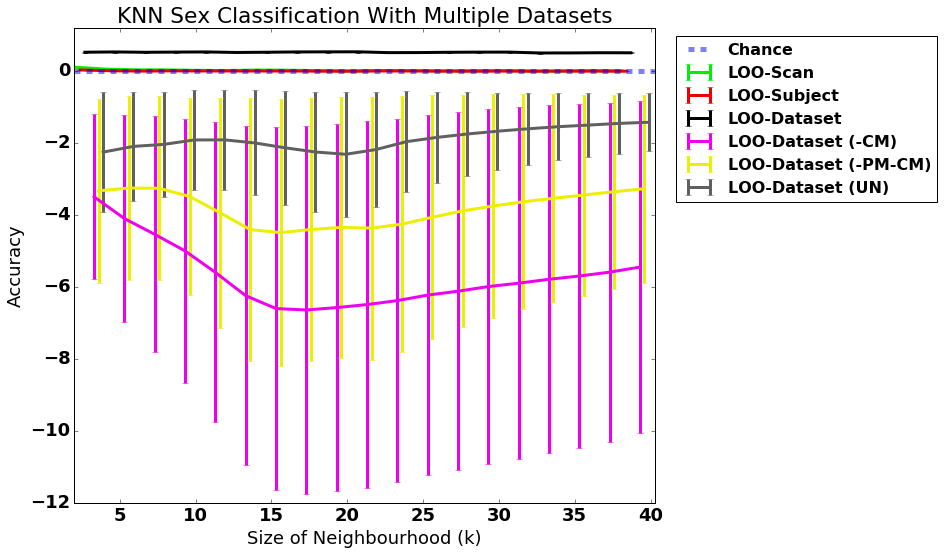

In [95]:
fig = plt.figure(figsize=(1.2*8,8))
plt.errorbar(neighbourhoods-0.9, mean_loo_scan, std_loo_scan/np.sqrt(len(ages)), lw=3, color='#00ee00')
plt.errorbar(neighbourhoods-0.6, mean_loo_subj, std_loo_subj/np.sqrt(len(ages)), lw=3, color='#ee0000')
plt.hold(True)
plt.axhline(0, linestyle='--', lw=5, alpha=0.5, color="#0000ee")
plt.errorbar(neighbourhoods-0.3, mean_loo_dset, std_loo_dset/np.sqrt(len(dataset*1)), lw=3, color='#000000')
plt.errorbar(neighbourhoods+0.3, mean_loo_dset_cm, std_loo_dset_cm/np.sqrt(len(dataset*1)), lw=3, color='#ee00ee')
plt.errorbar(neighbourhoods+0.6, mean_loo_dset_pmcm, std_loo_dset_pmcm/np.sqrt(len(dataset*1)), lw=3, color='#eeee00')
plt.errorbar(neighbourhoods+0.9, mean_loo_dset_un, std_loo_dset_un/np.sqrt(len(dataset*1)), lw=3, color='#606060')

# plt.ylim((0.5, 0.7))
# plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlim([2, 40.3])
plt.ylim([-12, 1.2])
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('KNN Sex Classification With Multiple Datasets')
lgd = plt.legend(('Chance', 'LOO-Scan', 'LOO-Subject', 'LOO-Dataset',
                  'LOO-Dataset (-CM)', 'LOO-Dataset (-PM-CM)', 'LOO-Dataset (UN)'),
                 fontsize=16, bbox_to_anchor = (1.5, 1))
plt.tight_layout(1)
plt.savefig('../../figs/graphs/regression/knn_regress_desikan.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

-------

-------

## Semipar
- select corpus of graphs
- for all:
    - compute svd
    - pass singular vector to get_elbow function
    - store 2nd elbow
- set d to median 2nd elbow
- do pca on graphs, keep top d dimensions
- cluster graphs with knn, using procrustes distance as distance metric

In [62]:
def myd(x, y):
    return sum(np.abs(x - y) / (np.abs(x) + np.abs(y)))

knn_sp = OrderedDict()
dims = 20

for i in neighbourhoods:
    classif = KNeighborsClassifier(i, metric=myd)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]

        # take SVD and rotate data
        u, s, vh = svd(ft_train)
        ft_train_t = np.dot(u,np.diag(s))[:, 0:dims]
        classif.fit(ft_train_t, sx_train)

        ft_test_t = np.dot(ft_test, vh)[:, 0:dims]
        score = classif.score(ft_test_t, sx_test)
        tmp = np.append(tmp, score)

#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn_sp[i] = tmp

knn_loo_dset_pcax = np.array(())
knn_loo_dset_pcay = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pcax = np.append(knn_loo_dset_pcax, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pcay = np.append(knn_loo_dset_pcay, knn[i])

DistanceMetric.get_metric('pyfunc', func=myd)

In [58]:
import random

elbows = np.array(())

print random.choice(sbjs)

25737


```
getElbows <- function(dat, n = 3, threshold = FALSE, plot = TRUE) {
  if (is.matrix(dat)) {
      d <- sort(apply(dat,2,sd), decreasing=TRUE)
  } else {
      d <- sort(dat,decreasing=TRUE)
  }

  if (!is.logical(threshold))
      d <- d[d > threshold]
  
  p <- length(d)
  if (p == 0)
      stop(paste("d must have elements that are larger than the threshold ",
                 threshold), "!", sep="")

  lq <- rep(0.0, p)                     # log likelihood, function of q
  for (q in 1:p) {
      mu1 <- mean(d[1:q])
      mu2 <- mean(d[-(1:q)])              # = NaN when q = p
      sigma2 <- (sum((d[1:q] - mu1)^2) + sum((d[-(1:q)] - mu2)^2)) /
          (p - 1 - (q < p))
      lq[q] <- sum( dnorm(  d[1:q ], mu1, sqrt(sigma2), log=TRUE) ) +
          sum( dnorm(d[-(1:q)], mu2, sqrt(sigma2), log=TRUE) )
  }
  
  q <- which.max(lq)
  if (n > 1 && q < (p-1)) {
      q <- c(q, q + getElbows(d[(q+1):p], n-1, plot=FALSE))
  }
  
  if (plot==TRUE) {
      if (is.matrix(dat)) {
          sdv <- d # apply(dat,2,sd)
          plot(sdv,type="b",xlab="dim",ylab="stdev")
          points(q,sdv[q],col=2,pch=19)
      } else {
          plot(dat, type="b")
          points(q,dat[q],col=2,pch=19)
      }
  }
  
  return(q)
}
```